# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'Luquillo'
main_str = 'RioGrande'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/24-Luquillo/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-02-11                   NaN                  NaN                  NaN   
1993-02-12                   NaN                  NaN                  NaN   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
1993-02-11                  NaN                   NaN                     NaN   
1993-02-12                  NaN                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
1993-02-11                    NaN                    NaN   
1993-02-12                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
1993-02-11                    NaN                      NaN  ...   
1993-02-12                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
1993-02-11                NaN                NaN                     NaN   
1993-02-12                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
1993-02-11                        NaN                        NaN   
1993-02-12                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
1993-02-11                        NaN                        NaN   
1993-02-12                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
1993-02-11                        NaN                        NaN   
1993-02-12                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
DateTime                               
1993-02-11                        NaN  
1993-02-12                        NaN  

[2 rows x 27 columns]

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
2019-09-29            1990.67104            385.10848           1362.03808   
2019-09-30            1478.13696            314.31648            696.59328   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
2019-09-29           699.424960                   NaN                     NaN   
2019-09-30           270.991776                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
2019-09-29                    NaN                    NaN   
2019-09-30                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
2019-09-29                    NaN                      NaN  ...   
2019-09-30                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
2019-09-29                NaN                NaN                     NaN   
2019-09-30                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
DateTime                               
2019-09-29                        NaN  
2019-09-30                        NaN  

[2 rows x 27 columns]

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['RioMameyes' 'RioSabana' 'RioGrande' 'RioIcacos' 'Sabana' 'EastPeak'
 'Bisley1' 'Bisley2' 'PuertoRico']
  
Discharge stations : ['RioMameyes', 'RioSabana', 'RioGrande', 'RioIcacos']
  
Meteorology stations: ['Sabana', 'EastPeak', 'Bisley1', 'Bisley2', 'PuertoRico']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

RioGrande_Discharge


In [7]:
len(nameHydrMetStation)

5

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-10-01             1585.7408            368.11840             594.6528   
1993-10-02             1076.0384            229.36608             339.8016   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
1993-10-01            144.41568                   NaN                     NaN   
1993-10-02            164.23744                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
1993-10-01                    NaN                    NaN   
1993-10-02                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
1993-10-01                    NaN                      NaN  ...   
1993-10-02                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
1993-10-01                NaN                NaN                     NaN   
1993-10-02                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
DateTime                               
1993-10-01                        NaN  
1993-10-02                        NaN  

[2 rows x 27 columns]

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
2019-09-29            1990.67104            385.10848           1362.03808   
2019-09-30            1478.13696            314.31648            696.59328   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
2019-09-29           699.424960                   NaN                     NaN   
2019-09-30           270.991776                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
2019-09-29                    NaN                    NaN   
2019-09-30                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
2019-09-29                    NaN                      NaN  ...   
2019-09-30                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
2019-09-29                NaN                NaN                     NaN   
2019-09-30                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
2019-09-29                        NaN                        NaN   
2019-09-30                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
DateTime                               
2019-09-29                        NaN  
2019-09-30                        NaN  

[2 rows x 27 columns]

trimmed row number is  232


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [10]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

In [15]:
table1.index.sort_values()

DatetimeIndex(['1993-10-01', '1993-10-02', '1993-10-03', '1993-10-04',
               '1993-10-05', '1993-10-06', '1993-10-07', '1993-10-08',
               '1993-10-09', '1993-10-10',
               ...
               '2019-09-21', '2019-09-22', '2019-09-23', '2019-09-24',
               '2019-09-25', '2019-09-26', '2019-09-27', '2019-09-28',
               '2019-09-29', '2019-09-30'],
              dtype='datetime64[ns]', name='DateTime', length=9496, freq=None)

 
0 RioMameyes_Discharge :No missing data!
 
1 RioSabana_Discharge :No missing data!
 
2 RioGrande_Discharge :No missing data!
3 RioIcacos_Discharge index of interpolated length = 1
No filled values are out of original data range
 
4 Sabana_Precipitation index of interpolated length = 120
No filled values are out of original data range
 
5 EastPeak_Precipitation index of interpolated length = 151
No filled values are out of original data range
 
6 Bisley1_Precipitation index of interpolated length = 167
No filled values are out of original data range
 
7 Bisley2_Precipitation index of interpolated length = 27
No filled values are out of original data range
 
8 Sabana_AirTemperature index of interpolated length = 160
No filled values are out of original data range
 
9 EastPeak_AirTemperature index of interpolated length = 315
No filled values are out of original data range
 
10 Sabana_RelativeHumidity index of interpolated length = 235
No filled values are out of original data range
 
1

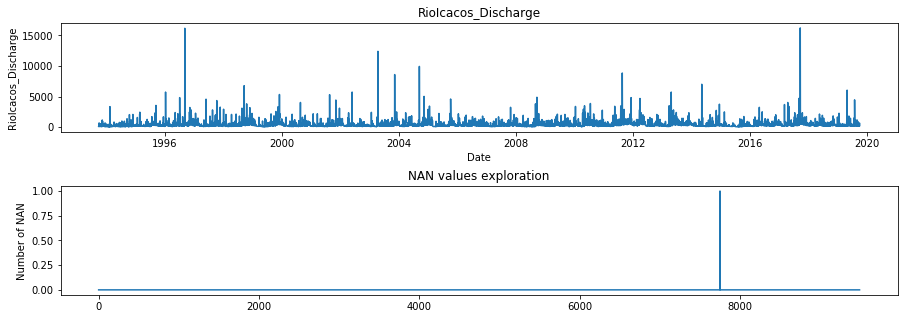

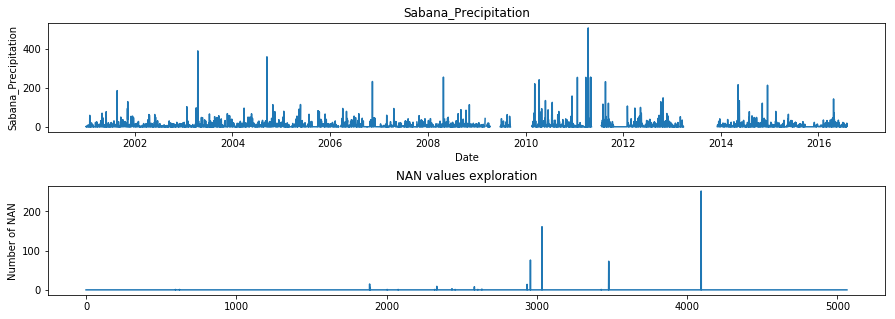

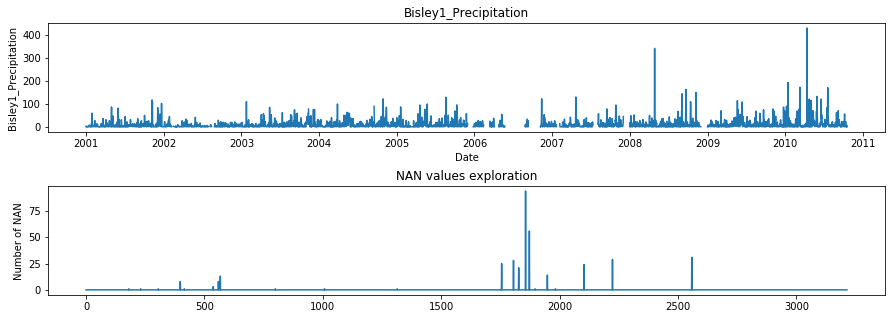

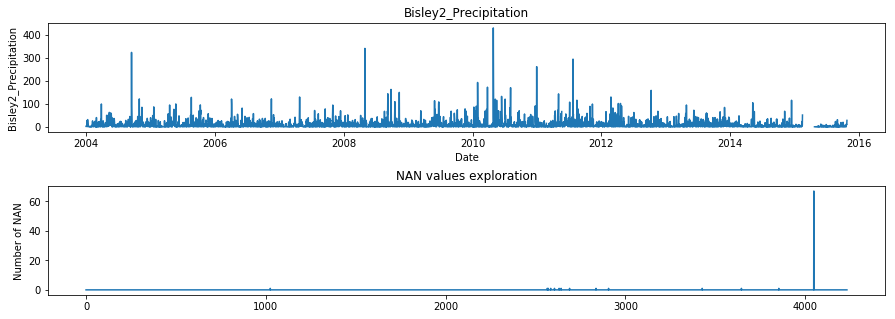

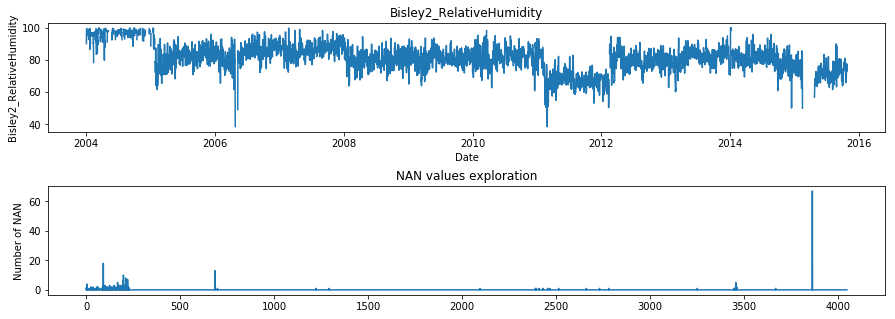

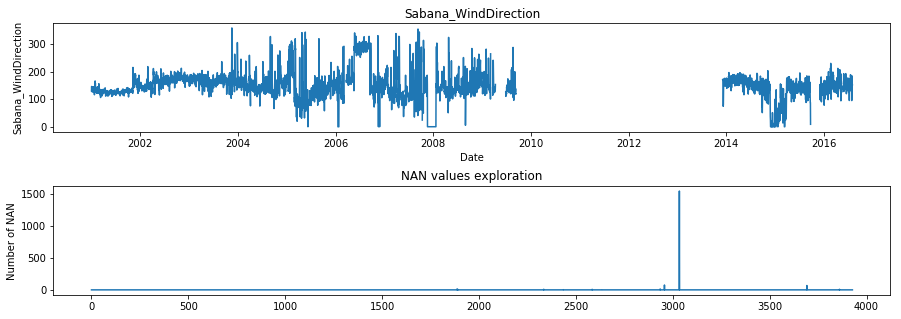

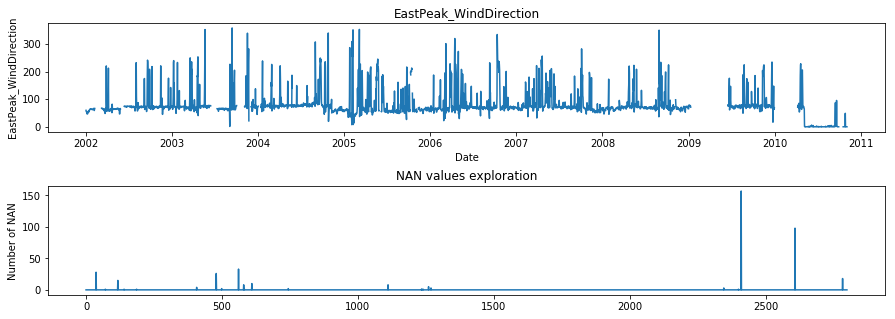

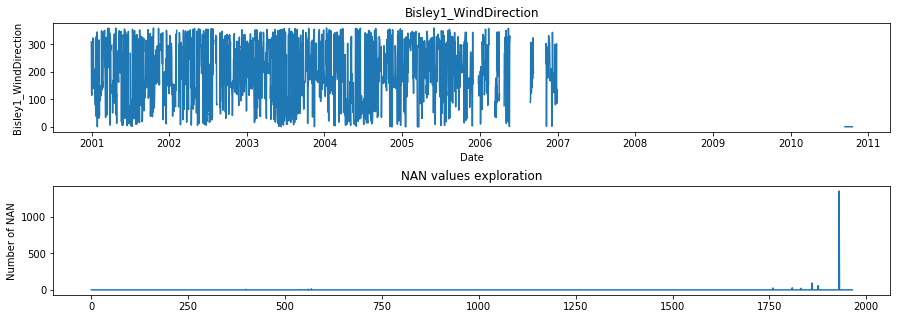

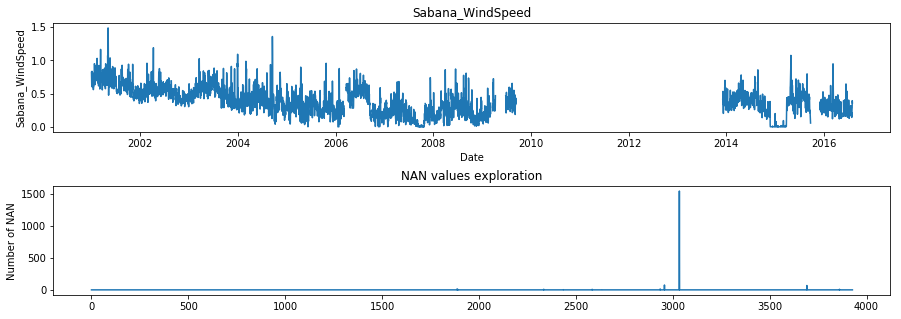

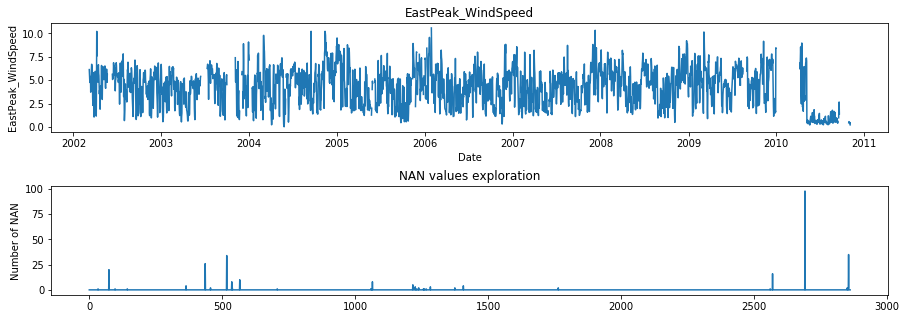

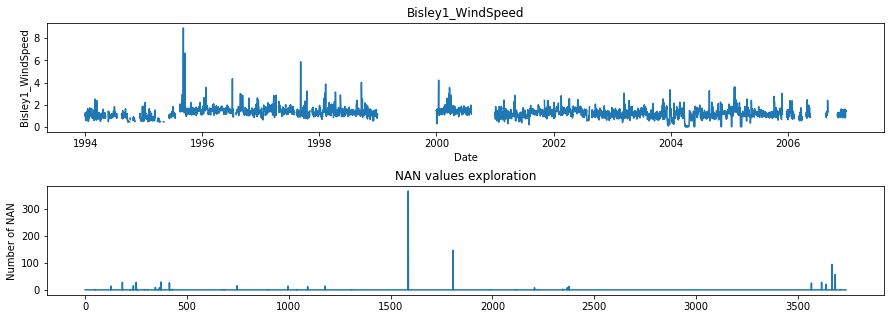

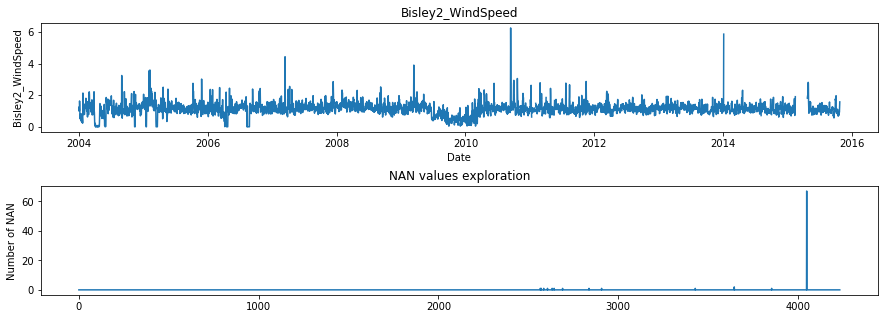

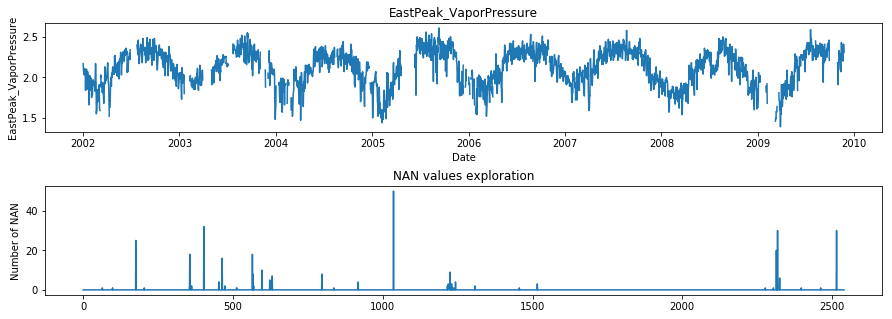

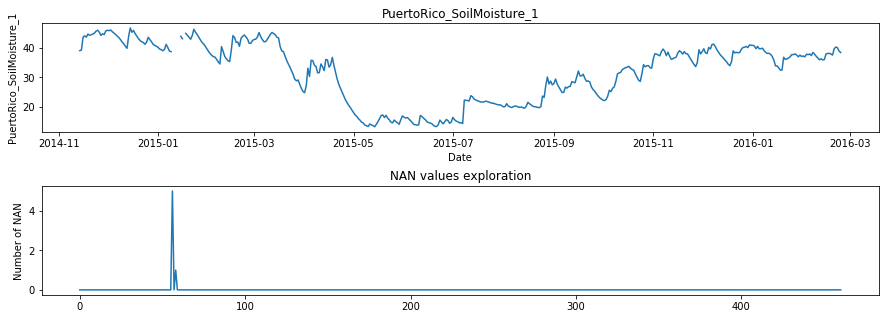

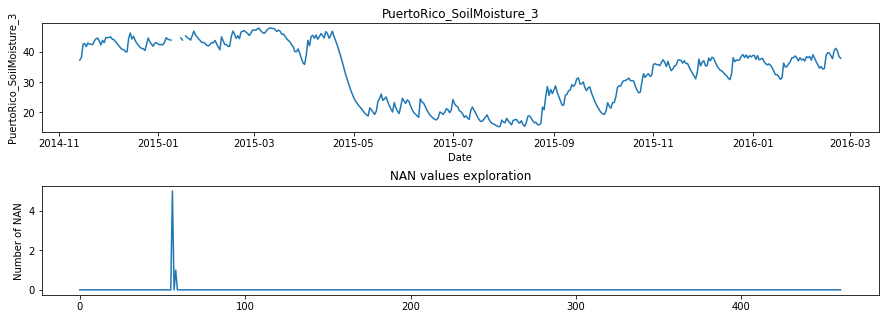

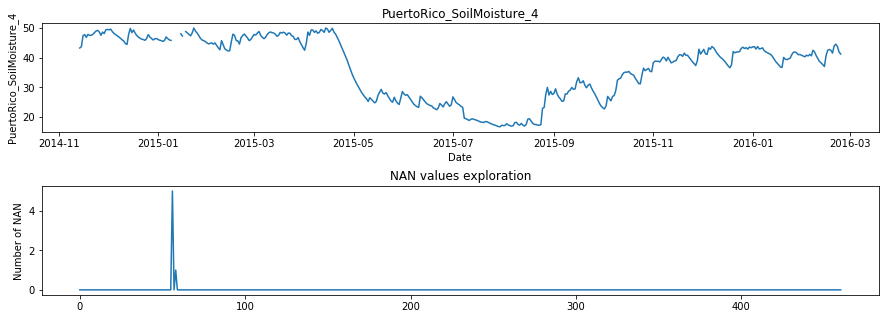

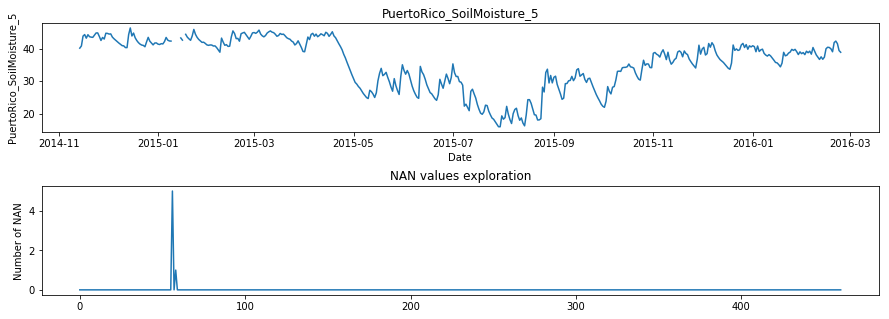

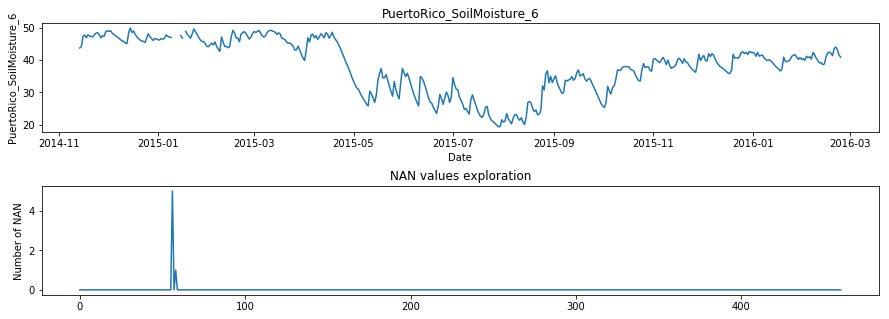

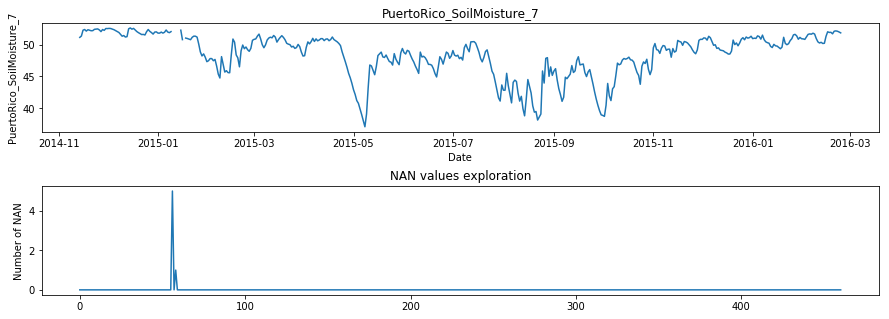

In [16]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table1, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [17]:
flag_table2.head(2)

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-10-01                   1.0                  1.0                  1.0   
1993-10-02                   1.0                  1.0                  1.0   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
1993-10-01                  1.0                   NaN                     NaN   
1993-10-02                  1.0                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
1993-10-01                    NaN                    NaN   
1993-10-02                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
1993-10-01                    NaN                      NaN  ...   
1993-10-02                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
1993-10-01                NaN                NaN                     NaN   
1993-10-02                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
DateTime                               
1993-10-01                        NaN  
1993-10-02                        NaN  

[2 rows x 27 columns]

In [18]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [19]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [20]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [21]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'RelativeHumidity'
 'WindDirection' 'WindSpeed' 'VaporPressure' 'SoilMoisture']


True

1 / 9 in process: RioMameyes Discharge
 
No Precipitation data at station RioMameyes
 
No AirTemperature data at station RioMameyes
 
No RelativeHumidity data at station RioMameyes
 
No WindDirection data at station RioMameyes
 
No WindSpeed data at station RioMameyes
 
No VaporPressure data at station RioMameyes
 
No SoilMoisture data at station RioMameyes
 
2 / 9 in process: RioSabana Discharge
 
No Precipitation data at station RioSabana
 
No AirTemperature data at station RioSabana
 
No RelativeHumidity data at station RioSabana
 
No WindDirection data at station RioSabana
 
No WindSpeed data at station RioSabana
 
No VaporPressure data at station RioSabana
 
No SoilMoisture data at station RioSabana
 
3 / 9 in process: RioGrande Discharge
 
No Precipitation data at station RioGrande
 
No AirTemperature data at station RioGrande
 
No RelativeHumidity data at station RioGrande
 
No WindDirection data at station RioGrande
 
No WindSpeed data at station RioGrande
 
No VaporPressure da

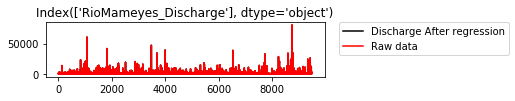

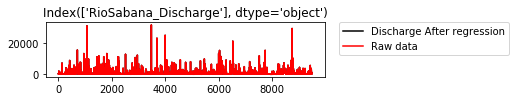

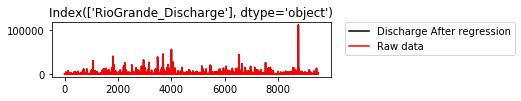

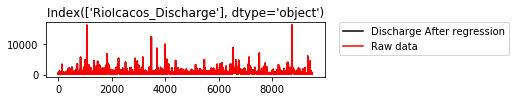

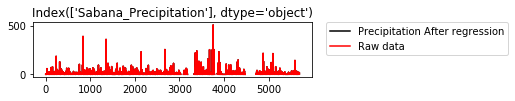

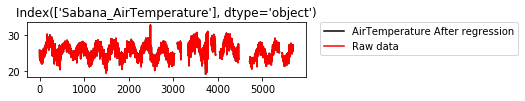

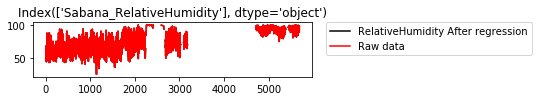

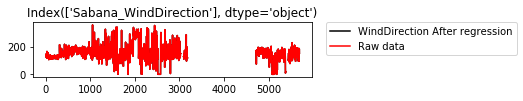

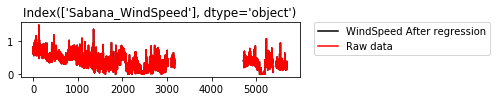

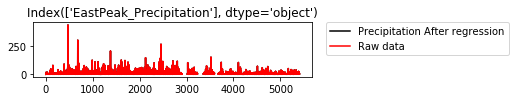

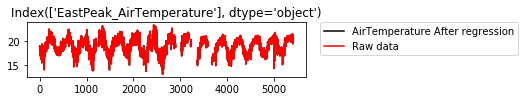

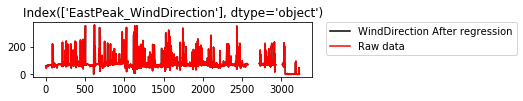

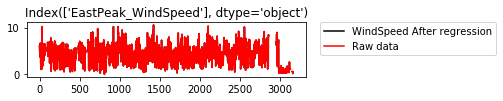

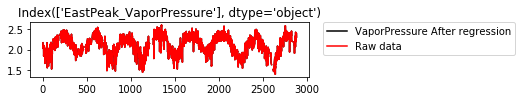

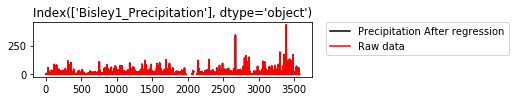

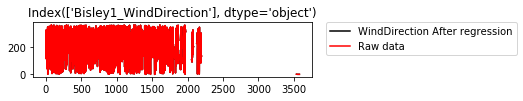

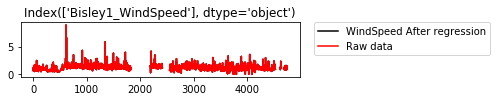

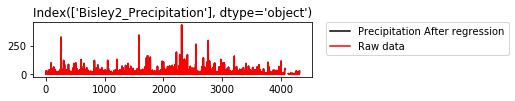

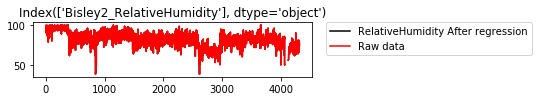

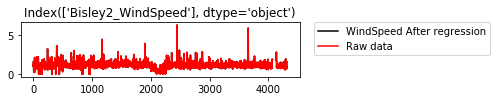

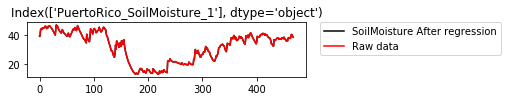

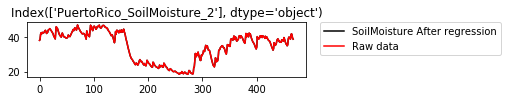

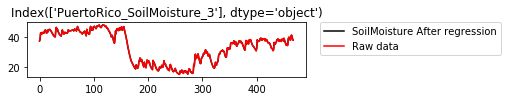

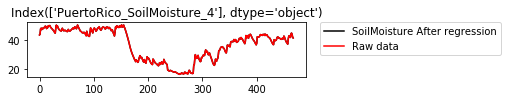

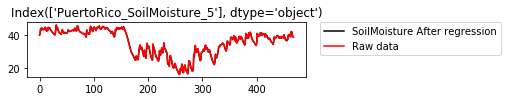

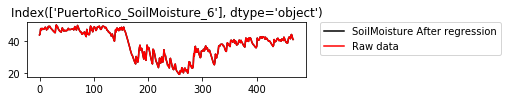

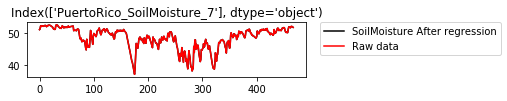

In [22]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [23]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [25]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table1, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original dat

In [26]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [27]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-10-01             1585.7408            368.11840             594.6528   
1993-10-02             1076.0384            229.36608             339.8016   

            RioIcacos_Discharge  
DateTime                         
1993-10-01            144.41568  
1993-10-02            164.23744

In [28]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:135: RuntimeWarning: Mean of empty slice
  AnnualMean = (np.nanmean(AnnualTable,axis=0)) #(np.nanmedian(AnnualTable,axis=0))
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:137: RuntimeWarning: All-NaN slice encountered
  AnnualMax = (np.nanmax(AnnualTable,axis=0)) # for outliers MAx
/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions/Source_QC_functions_L.py:138: RuntimeWarning: All-NaN slice encountered
  AnnualMin = (np.nanmin(AnnualTable,axis=0)) # minimum


0 RioMameyes_Discharge 0
1 RioSabana_Discharge 0
2 RioGrande_Discharge 0
3 RioIcacos_Discharge 0
4 Sabana_Precipitation 102
5 EastPeak_Precipitation 43
6 Bisley1_Precipitation 53
7 Bisley2_Precipitation 0
8 Sabana_AirTemperature 121
9 EastPeak_AirTemperature 107
10 Sabana_RelativeHumidity 147
11 Bisley2_RelativeHumidity 4
12 Sabana_WindDirection 55
13 EastPeak_WindDirection 46
14 Bisley1_WindDirection 11
15 Sabana_WindSpeed 55
16 EastPeak_WindSpeed 40
17 Bisley1_WindSpeed 68
18 Bisley2_WindSpeed 0
19 EastPeak_VaporPressure 113
20 PuertoRico_SoilMoisture_1 0
21 PuertoRico_SoilMoisture_2 0
22 PuertoRico_SoilMoisture_3 0
23 PuertoRico_SoilMoisture_4 0
24 PuertoRico_SoilMoisture_5 0
25 PuertoRico_SoilMoisture_6 0
26 PuertoRico_SoilMoisture_7 0


In [29]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [30]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table1, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original dat

In [31]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [32]:
table4.head()

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-10-01             1585.7408            368.11840            594.65280   
1993-10-02             1076.0384            229.36608            339.80160   
1993-10-03             1585.7408            283.16800            424.75200   
1993-10-04             1132.6720            311.48480            396.43520   
1993-10-05              849.5040            184.05920            252.01952   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
1993-10-01            144.41568                   NaN                     NaN   
1993-10-02            164.23744                   NaN                     NaN   
1993-10-03            254.85120                   NaN                     NaN   
1993-10-04            206.71264                   NaN                     NaN   
1993-10-05            138.75232                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
1993-10-01                    NaN                    NaN   
1993-10-02                    NaN                    NaN   
1993-10-03                    NaN                    NaN   
1993-10-04                    NaN                    NaN   
1993-10-05                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
1993-10-01                    NaN                      NaN  ...   
1993-10-02                    NaN                      NaN  ...   
1993-10-03                    NaN                      NaN  ...   
1993-10-04                    NaN                      NaN  ...   
1993-10-05                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
1993-10-01                NaN                NaN                     NaN   
1993-10-02                NaN                NaN                     NaN   
1993-10-03                NaN                NaN                     NaN   
1993-10-04                NaN                NaN                     NaN   
1993-10-05                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
Da

In [33]:
flag_table4.head()

RioMameyes_Discharge  RioSabana_Discharge  RioGrande_Discharge  \
DateTime                                                                     
1993-10-01                   1.0                  1.0                  1.0   
1993-10-02                   1.0                  1.0                  1.0   
1993-10-03                   1.0                  1.0                  1.0   
1993-10-04                   1.0                  1.0                  1.0   
1993-10-05                   1.0                  1.0                  1.0   

            RioIcacos_Discharge  Sabana_Precipitation  EastPeak_Precipitation  \
DateTime                                                                        
1993-10-01                  1.0                   NaN                     NaN   
1993-10-02                  1.0                   NaN                     NaN   
1993-10-03                  1.0                   NaN                     NaN   
1993-10-04                  1.0                   NaN                     NaN   
1993-10-05                  1.0                   NaN                     NaN   

            Bisley1_Precipitation  Bisley2_Precipitation  \
DateTime                                                   
1993-10-01                    NaN                    NaN   
1993-10-02                    NaN                    NaN   
1993-10-03                    NaN                    NaN   
1993-10-04                    NaN                    NaN   
1993-10-05                    NaN                    NaN   

            Sabana_AirTemperature  EastPeak_AirTemperature  ...  \
DateTime                                                    ...   
1993-10-01                    NaN                      NaN  ...   
1993-10-02                    NaN                      NaN  ...   
1993-10-03                    NaN                      NaN  ...   
1993-10-04                    NaN                      NaN  ...   
1993-10-05                    NaN                      NaN  ...   

            Bisley1_WindSpeed  Bisley2_WindSpeed  EastPeak_VaporPressure  \
DateTime                                                                   
1993-10-01                NaN                NaN                     NaN   
1993-10-02                NaN                NaN                     NaN   
1993-10-03                NaN                NaN                     NaN   
1993-10-04                NaN                NaN                     NaN   
1993-10-05                NaN                NaN                     NaN   

            PuertoRico_SoilMoisture_1  PuertoRico_SoilMoisture_2  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_3  PuertoRico_SoilMoisture_4  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_5  PuertoRico_SoilMoisture_6  \
DateTime                                                           
1993-10-01                        NaN                        NaN   
1993-10-02                        NaN                        NaN   
1993-10-03                        NaN                        NaN   
1993-10-04                        NaN                        NaN   
1993-10-05                        NaN                        NaN   

            PuertoRico_SoilMoisture_7  
Da

In [34]:
table4.shape

(9496, 27)

In [35]:
flag_table4.shape

(9496, 27)